In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/quickdraw-doodle-recognition/sample_submission.csv
/kaggle/input/quickdraw-doodle-recognition/test_raw.csv
/kaggle/input/quickdraw-doodle-recognition/test_simplified.csv
/kaggle/input/quickdraw-doodle-recognition/train_simplified/traffic light.csv
/kaggle/input/quickdraw-doodle-recognition/train_simplified/rhinoceros.csv
/kaggle/input/quickdraw-doodle-recognition/train_simplified/bed.csv
/kaggle/input/quickdraw-doodle-recognition/train_simplified/school bus.csv
/kaggle/input/quickdraw-doodle-recognition/train_simplified/van.csv
/kaggle/input/quickdraw-doodle-recognition/train_simplified/octopus.csv
/kaggle/input/quickdraw-doodle-recognition/train_simplified/firetruck.csv
/kaggle/input/quickdraw-doodle-recognition/train_simplified/laptop.csv
/kaggle/input/quickdraw-doodle-recognition/train_simplified/tractor.csv
/kaggle/input/quickdraw-doodle-recognition/train_simplified/matches.csv
/kaggle/input/quickdraw-doodle-recognition/train_simplified/windmill.csv
/kaggle/input/quic

In [2]:
# limit memory to prevent data leak
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

2 Physical GPUs, 2 Logical GPUs


In [3]:
import numpy as np
import pandas as pd
import json
import gc
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
import os
train_files = glob("../input/quickdraw-doodle-recognition/train_simplified/*.csv")
rows = 200000
rows = rows - (rows % 340)
cat_size = rows // 340
print(cat_size)
gc.collect()

588


56

In [4]:
from PIL import Image, ImageDraw
from dask import bag
def drawStrokes(matrixOfStrokes):
    image = Image.new("RGB", (256,256), color=255)
    image_draw = ImageDraw.Draw(image)
    for stroke in json.loads(matrixOfStrokes):
        for i in range(len(stroke[0])-1):
            image_draw.line([stroke[0][i], 
                             stroke[1][i],
                             stroke[0][i+1], 
                             stroke[1][i+1]],
                            fill=0, width=5)
    return np.array(image.resize((32,32)))/255.

In [5]:
drawingArray = np.zeros((rows,32,32,3))
categories = pd.Series([None] * rows)
i = 0
for f in train_files:
    for df in pd.read_csv(f, index_col="key_id", chunksize=1000, nrows=cat_size):
        imagebag = bag.from_sequence(df.drawing.values).map(drawStrokes)
        imagebag = np.array(imagebag.compute())
        categories[i:(i + imagebag.shape[0])] = df["word"].replace("\s+", "_", regex=True)
        drawingArray[i:(i + imagebag.shape[0])] = imagebag
        i += imagebag.shape[0]
        print(i)

588
1176
1764
2352
2940
3528
4116
4704
5292
5880
6468
7056
7644
8232
8820
9408
9996
10584
11172
11760
12348
12936
13524
14112
14700
15288
15876
16464
17052
17640
18228
18816
19404
19992
20580
21168
21756
22344
22932
23520
24108
24696
25284
25872
26460
27048
27636
28224
28812
29400
29988
30576
31164
31752
32340
32928
33516
34104
34692
35280
35868
36456
37044
37632
38220
38808
39396
39984
40572
41160
41748
42336
42924
43512
44100
44688
45276
45864
46452
47040
47628
48216
48804
49392
49980
50568
51156
51744
52332
52920
53508
54096
54684
55272
55860
56448
57036
57624
58212
58800
59388
59976
60564
61152
61740
62328
62916
63504
64092
64680
65268
65856
66444
67032
67620
68208
68796
69384
69972
70560
71148
71736
72324
72912
73500
74088
74676
75264
75852
76440
77028
77616
78204
78792
79380
79968
80556
81144
81732
82320
82908
83496
84084
84672
85260
85848
86436
87024
87612
88200
88788
89376
89964
90552
91140
91728
92316
92904
93492
94080
94668
95256
95844
96432
97020
97608
98196
98784
99372
9996

In [6]:
# import glob
# path = "/kaggle/input/quickdraw-doodle-recognition/train_simplified/"
# all_files = glob.glob(path+'/*.csv')
# all_files

In [7]:
# gc.collect()

In [8]:
from sklearn.model_selection import train_test_split
indecator = pd.get_dummies(categories)
tr_x,tst_x,tr_indecator,tst_indecator = train_test_split(drawingArray, indecator, test_size=0.2,random_state=25)

In [9]:
categories


0         traffic_light
1         traffic_light
2         traffic_light
3         traffic_light
4         traffic_light
              ...      
199915             fish
199916             fish
199917             fish
199918             fish
199919             fish
Length: 199920, dtype: object

In [10]:
del drawingArray,categories
gc.collect()

21

In [11]:
from sklearn.model_selection import train_test_split
import numpy as np
X_train,X_test,y_train,y_test = train_test_split(df.drawing,df.word,test_size=0.2,random_state=4)
X_train.head()
# list(df.drawing)

key_id
5243588512317440    [[[0, 24, 57, 77, 121, 145, 160, 215, 240, 251...
4657284535812096    [[[0, 20, 36, 61, 100, 119, 160, 197, 213, 230...
5150184784789504    [[[255, 204, 175, 141, 103, 84, 57, 46, 35, 20...
6277817811599360    [[[52, 50, 43, 39, 28, 28, 24, 14, 16, 24, 36,...
6608601932103680    [[[242, 242, 238, 212, 200, 153, 135, 122, 113...
Name: drawing, dtype: object

In [12]:
# from keras.models import Sequential
# from keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,Activation
# import tensorflow as tf
# model = Sequential()
# model.add(Conv2D(128,kernel_size=(5,5),padding="same",activation="relu",input_shape=(32,32,3)))
# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Dropout(0.25))

# model.add(Conv2D(64,kernel_size=(3,3),padding="same",activation="relu")
# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Dropout(0.25))
          
# model.add(Conv2D(64,kernel_size=(3,3),padding="same",activation="relu")
# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Dropout(0.25))

# model.add(Flatten())
# model.add(Dense(1024,activation="relu"))

# model.add(Dense(512,activation="relu"))

# model.add(Dropout(0.3))

# model.add(Dense(340,activation="softmax"))


# model.compile(loss='categorical_crossentropy',
#               optimizer='adam',
#               metrics=['accuracy'])

In [13]:
import keras
from keras.models import Sequential,Model
from keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,Activation
from tensorflow.keras.optimizers.legacy import Adam

strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    model = Sequential()
    model.add(Conv2D(256,kernel_size=(3,3),activation="relu",input_shape=(32,32,3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(128, kernel_size=(3,3), strides=1,activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(2048,activation="relu"))
    model.add(Dropout(0.25))
    model.add(Dense(1024,activation="relu"))
    model.add(Dropout(0.25))
    model.add(Dense(512,activation="relu"))
    model.add(Dropout(0.25))
    model.add(Dense(340,activation="relu"))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(learning_rate=0.0001),
                  metrics=['accuracy'])


In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 256)       7168      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 256)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 15, 15, 256)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 128)       295040    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 128)        0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 6, 6, 128)         0

Epoch 1/30


2023-03-19 07:37:52.722231: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


800/800 [==============================] - 55s 53ms/step - loss: 5.8223 - accuracy: 0.0038 - val_loss: 5.7056 - val_accuracy: 0.0196
Epoch 2/30
800/800 [==============================] - 38s 47ms/step - loss: 5.4031 - accuracy: 0.0424 - val_loss: 5.0473 - val_accuracy: 0.0957
Epoch 3/30
800/800 [==============================] - 37s 47ms/step - loss: 4.9456 - accuracy: 0.1058 - val_loss: 4.6010 - val_accuracy: 0.1727
Epoch 4/30
800/800 [==============================] - 38s 47ms/step - loss: 4.5632 - accuracy: 0.1660 - val_loss: 4.2306 - val_accuracy: 0.2326
Epoch 5/30
800/800 [==============================] - 37s 47ms/step - loss: 4.2789 - accuracy: 0.2149 - val_loss: 3.9870 - val_accuracy: 0.2739
Epoch 6/30
800/800 [==============================] - 38s 47ms/step - loss: 4.0811 - accuracy: 0.2503 - val_loss: 3.8335 - val_accuracy: 0.3056
Epoch 7/30
800/800 [==============================] - 38s 47ms/step - loss: 3.9332 - accuracy: 0.2765 - val_loss: 3.7194 - val_accuracy: 0.3251
Epo

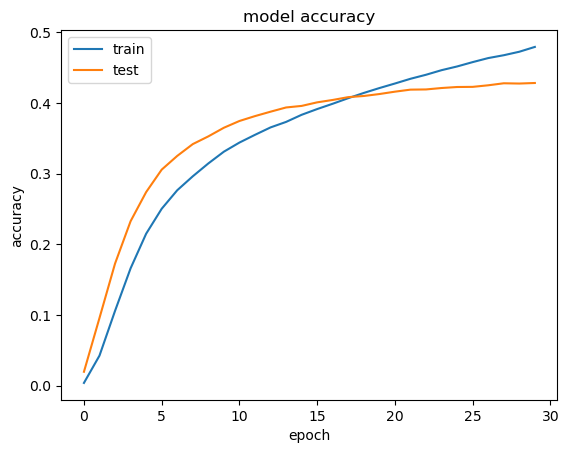

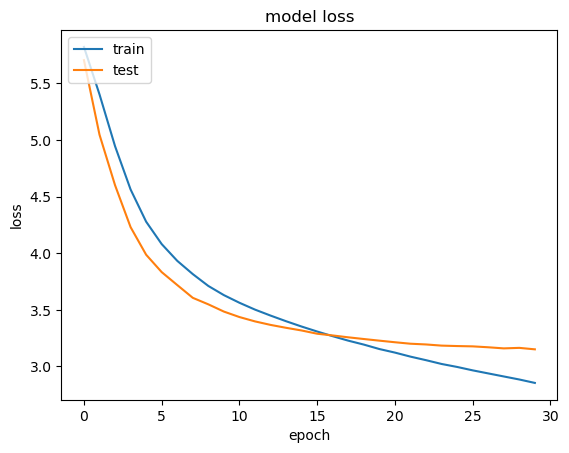

In [15]:
history = model.fit(tr_x, tr_indecator,batch_size=200,epochs=30
          ,validation_data=(tst_x,tst_indecator))

print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [16]:
# Epoch 3/30
# 600/600 [==============================] - 18s 31ms/step - loss: 3.9758 - accuracy: 0.1538 - val_loss: 3.4755 - val_accuracy: 0.2401
# Epoch 30/30
# 600/600 [==============================] - 18s 30ms/step - loss: 2.2876 - accuracy: 0.4391 - val_loss: 2.1696 - val_accuracy: 0.4867
from tensorflow.keras.models import save_model
save_model(model,"CNN_30ep_20kdata_4layers.h5")

In [17]:
1024/2

512.0